Original shape: (9310, 33)
  End_of_Period Loan_Number                       Region  \
0    05/31/2025   IBRDB1051        EAST ASIA AND PACIFIC   
1    05/31/2025   IBRDB1060        EAST ASIA AND PACIFIC   
2    05/31/2025   IBRDB1061        EAST ASIA AND PACIFIC   
3    05/31/2025   IBRD00180  LATIN AMERICA AND CARIBBEAN   
4    05/31/2025   IBRD00380  LATIN AMERICA AND CARIBBEAN   

  Country___Economy_Code Country___Economy  \
0                     CN             China   
1                     CN             China   
2                     CN             China   
3                     CO          Colombia   
4                     CO          Colombia   

                                   Borrower Guarantor_Country___Economy_Code  \
0                       MINISTRY OF FINANCE                               CN   
1                       MINISTRY OF FINANCE                               CN   
2                       MINISTRY OF FINANCE                               CN   
3  MINISTERIO D

C:\Users\praso\AppData\Local\Temp\ipykernel_7224\1878647639.py:61: RuntimeWarning: Precision loss occurred in moment calculation due to catastrophic cancellation. This occurs when the data are nearly identical. Results may be unreliable.
  z_scores = np.abs(zscore(df[num_cols]))


Shape after outlier removal: (9183, 24087)


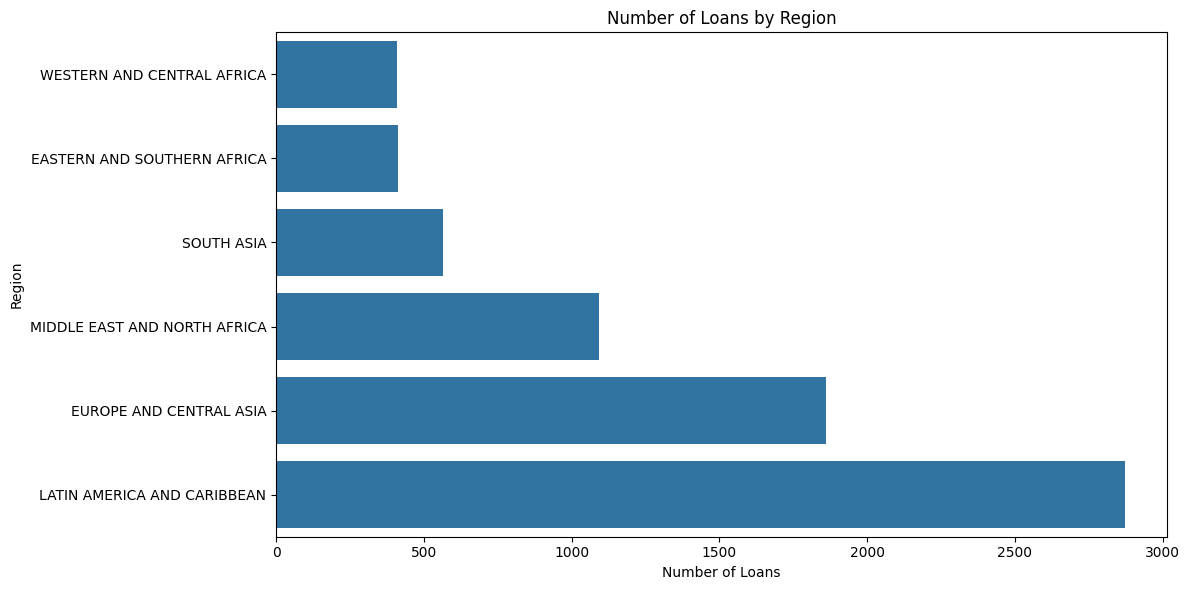

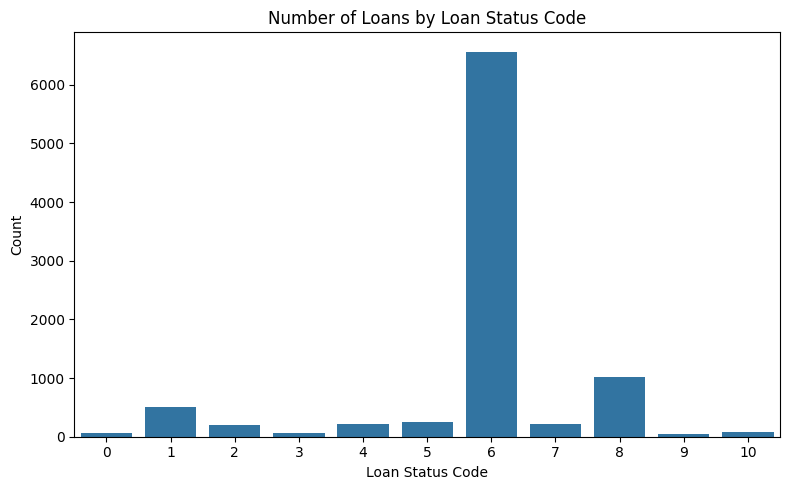


✅ Model Evaluation Report:
Accuracy Score: 0.9982578397212544

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00        15
           1       1.00      1.00      1.00       135
           2       1.00      1.00      1.00        44
           3       0.87      1.00      0.93        13
           4       0.98      1.00      0.99        57
           5       1.00      0.99      0.99        68
           6       1.00      1.00      1.00      1621
           7       1.00      1.00      1.00        59
           8       1.00      1.00      1.00       256
           9       1.00      0.82      0.90        11
          10       1.00      0.94      0.97        17

    accuracy                           1.00      2296
   macro avg       0.99      0.98      0.98      2296
weighted avg       1.00      1.00      1.00      2296


Confusion Matrix:
 [[  15    0    0    0    0    0    0    0    0    0    0]
 [   0  135    0    0

In [ ]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from scipy.stats import zscore

# Step 2: Load the Dataset
df = pd.read_csv(r'C:\Users\praso\Downloads\ibrd_statement_of_loans_and_guarantees_latest_available_snapshot_06-27-2025.csv')

# Step 3: Preview and Clean Column Names
print("Original shape:", df.shape)
df.columns = df.columns.str.strip().str.replace(' ', '_').str.replace('/', '_')
print(df.head())

# Step 4: Data Info
df.info()

# Step 5: Handle Missing Values
threshold = len(df) * 0.5
df = df.loc[:, df.isnull().sum() < threshold]
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Step 6: Remove Duplicates
df.drop_duplicates(inplace=True)

# Step 7: Convert Date Columns
date_cols = ['First_Repayment_Date', 'Last_Repayment_Date', 'Agreement_Signing_Date',
             'Board_Approval_Date', 'Effective_Date_(Most_Recent)', 'Closed_Date_(Most_Recent)',
             'Last_Disbursement_Date', 'End_of_Period']
for col in date_cols:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors='coerce')

# Step 8: Extract Features from Date Columns
if 'Agreement_Signing_Date' in df.columns and 'Closed_Date_(Most_Recent)' in df.columns:
    df['Loan_Duration_Days'] = (df['Closed_Date_(Most_Recent)'] - df['Agreement_Signing_Date']).dt.days

for col in ['Agreement_Signing_Date', 'Board_Approval_Date', 'Effective_Date_(Most_Recent)', 'Closed_Date_(Most_Recent)', 'End_of_Period']:
    if col in df.columns:
        df[col + '_Year'] = df[col].dt.year
        df[col + '_Month'] = df[col].dt.month

df.drop(columns=date_cols, inplace=True)

# Step 9: Encode Target
if 'Loan_Status' in df.columns:
    df['Loan_Status_Code'] = df['Loan_Status'].astype('category').cat.codes

# Step 10: Encode Categorical Columns
cat_cols = df.select_dtypes(include=['object']).columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Step 11: Outlier Detection (flexible filter)
num_cols = df.select_dtypes(include=[np.number]).columns
z_scores = np.abs(zscore(df[num_cols]))
df = df[(z_scores < 3).sum(axis=1) >= (len(num_cols) // 2)]
print("Shape after outlier removal:", df.shape)

# Step 12: Scale Numerical Columns (excluding target)
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if 'Loan_Status_Code' in num_cols:
    num_cols.remove('Loan_Status_Code')  # Don't scale target

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

# Step 13: Visualizations
# Loans by Region (if available before encoding)
if any(col.startswith('Region_') for col in df.columns):
    region_cols = [col for col in df.columns if col.startswith('Region_')]
    region_sums = df[region_cols].sum().sort_values()
    plt.figure(figsize=(12, 6))
    sns.barplot(x=region_sums.values, y=region_sums.index.str.replace('Region_', ''))
    plt.title('Number of Loans by Region')
    plt.xlabel('Number of Loans')
    plt.ylabel('Region')
    plt.tight_layout()
    plt.show()

# Loans by Loan Status (based on encoded values)
if 'Loan_Status_Code' in df.columns:
    plt.figure(figsize=(8, 5))
    sns.countplot(x=df['Loan_Status_Code'])
    plt.title('Number of Loans by Loan Status Code')
    plt.xlabel('Loan Status Code')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# Step 14: Modeling
# Define original columns to drop (only if they still exist)
drop_cols = ['Loan_Status', 'Loan_Number', 'Country__Economy', 'Borrower', 'Guarantor', 
             'Region', 'Country__Economy_Code', 'Guarantor_Country__Economy_Code']
all_drop_cols = drop_cols + ['Loan_Status_Code']
safe_drop_cols = [col for col in all_drop_cols if col in df.columns]

# Define X and y
X = df.drop(columns=safe_drop_cols)
y = df['Loan_Status_Code']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Step 15: Train Model
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

# Step 16: Evaluate Model
y_pred = clf.predict(X_test)
print("\n✅ Model Evaluation Report:")
print("Accuracy Score:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Step 17: Feature Importance
importances = clf.feature_importances_
features = X.columns
sorted_indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 6))
sns.barplot(x=importances[sorted_indices], y=features[sorted_indices])
plt.title("Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
